In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# 読み込み
# path = "/content/drive/My Drive/Colab Notebooks/gci/competition_1/"
path = "./"
df_origin = pd.read_csv(path + 'data/train.csv')
df_test_origin = pd.read_csv(path + 'data/test.csv')

In [2]:
df = df_origin.copy()
df_test = df_test_origin.copy()
print(df.shape, df_test.shape)
# df.head()

(891, 12) (418, 11)


## 分析、前処理

- 欠損あり:Age, Fare, Cabin, Embarked
- 使いたいカラム:PassengerId, Pclass(1, 2, 3 → 0, 0.5, 1), Sex(f, m → 0, 1), Age(標準化する？), SibSpとParch(標準化する？), Embarked(QとSのワンホットエンコーディングにする)
- 落とすカラム:Name, Ticket, Cabin(生死と無関係であると思われるため), Fare(Pclassと多重共線のため)

In [3]:
# 生存率は38%
len(df.loc[df.Perished == 0]) / len(df)

0.3838383838383838

In [4]:
# PclassとSexごとに、Ageの平均を求める
df_all = pd.concat([df, df_test])
df_mean_age = df_all.groupby(['Sex', 'Pclass'], as_index=False)[['Age']].mean()

# mergeすることで、Ageの補完する
df_all_with_age = df_all.merge(df_mean_age, on=['Sex', 'Pclass'], how='left')
df_all_with_age['Age_x'].fillna(df_all_with_age['Age_y'], inplace=True)
df_all_with_age.drop(columns=['Age_y'], inplace=True)
df_all_with_age.rename(columns={'Age_x': 'Age'}, inplace=True)

# Age, Sibsp, Parch列に対してStandardScalerを適用する
for column_name in ['Age', 'SibSp', 'Parch']:
    scaler = StandardScaler()
    df_all_with_age[[column_name]] = scaler.fit_transform(df_all_with_age[[column_name]])

df_all = df_all_with_age


# PClassを1, 2, 3から0, 0.5, 1にする
df_all['Pclass'] = df_all['Pclass'] / 2 - 0.5 # jun13 20:15 submit
# df_all['Pclass'] = df_all['Pclass'] - 2

# それ以外のカラムの処理
df_all.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_all.drop(columns=['Cabin', 'Fare', 'Ticket', 'Name'], inplace=True)


df = df_all.iloc[:891]
df['Perished'] = df.Perished.astype(int)
df_test = df_all.iloc[891:].drop(columns=['Perished'])

# display(df)
# display(df_test)

In [5]:
# Embarkedの処理

# Sが多いので、Embarkedにおける2件の欠損はSで補完する
df['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

# OneHotEncodingする
embarked = pd.concat([df['Embarked'], df_test['Embarked']])
embarked_ohe = pd.get_dummies(embarked, drop_first=True)

embarked_ohe_train = embarked_ohe[:891]
embarked_ohe_test = embarked_ohe[891:]

df = pd.concat([df, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)

In [6]:
# 欠損値はなく、標準化も出来た

## 学習

In [7]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

X_test = df_test.iloc[:, 1:].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

Random Forest
Train Score: 0.844
 Test Score: 0.81

Support Vector Machine
Train Score: 0.838
 Test Score: 0.825

Logistic Regression
Train Score: 0.806
 Test Score: 0.821

KNeighbors
Train Score: 0.841
 Test Score: 0.799

Multi Perceptron
Train Score: 0.833
 Test Score: 0.821


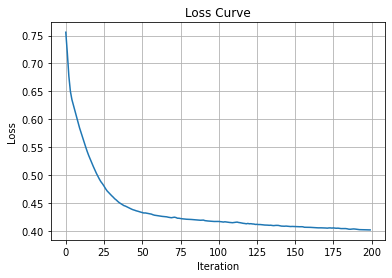

In [8]:
# ランダムフォレスト
rfc = RandomForestClassifier(max_depth=5, min_samples_leaf=1, n_estimators=50, max_features='sqrt', n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train) # trainデータにfitして、trainとvalidでの精度を見る
print('Random Forest')
print('Train Score: {}'.format(round(rfc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(rfc.score(X_valid, y_valid), 3)))

# サポートベクターマシン
svc = SVC(C=2, decision_function_shape='ovo', kernel='rbf', probability=True, random_state=42)
svc.fit(X_train, y_train)
print('\nSupport Vector Machine')
print('Train Score: {}'.format(round(svc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(svc.score(X_valid, y_valid), 3)))

# ロジステック
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
print('\nLogistic Regression')
print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(lr.score(X_valid, y_valid), 3)))

# K近傍
knc = KNeighborsClassifier(metric='minkowski', n_neighbors=13, p=1, weights='uniform')
knc.fit(X_train, y_train)
print('\nKNeighbors')
print('Train Score: {}'.format(round(knc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(knc.score(X_valid, y_valid), 3)))

# 多層パーセプトロン
mlpc = MLPClassifier(hidden_layer_sizes=(128,), solver='sgd', activation='relu', learning_rate_init=0.01, random_state=0)
# mlpc = MLPClassifier(hidden_layer_sizes=(100, 100, 10), solver='sgd', activation='relu', learning_rate_init=0.01, random_state=0)
mlpc.fit(X_train, y_train)
print('\nMulti Perceptron')
print('Train Score: {}'.format(round(mlpc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(mlpc.score(X_valid, y_valid), 3)))

%matplotlib inline
import matplotlib.pyplot as plt
plt.title("Loss Curve")
plt.plot(mlpc.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

## アンサンブリング

In [9]:
# 5つのモデル

rfc_pred_train = rfc.predict_proba(X_train)
lr_pred_train = lr.predict_proba(X_train)
mlpc_pred_train = mlpc.predict_proba(X_train)
svc_pred_train = svc.predict_proba(X_train)
knc_pred_train = knc.predict_proba(X_train)

# 死の確率と生の確率の2次元配列。argmaxで生か死を取り出す
# pred_proba_train = (rfc_pred_train + mlpc_pred_train + lr_pred_train + svc_pred_train) / 4
pred_proba_train = (rfc_pred_train + lr_pred_train + mlpc_pred_train + svc_pred_train + knc_pred_train) / 5
pred_train = pred_proba_train.argmax(axis=1)


accuracy_score(y_train, pred_train)

0.8459069020866774

In [14]:
rfc_pred = rfc.predict_proba(X_test)
lr_pred = lr.predict_proba(X_test)
mlpc_pred = mlpc.predict_proba(X_test)
svc_pred = svc.predict_proba(X_test)
knc_pred = knc.predict_proba(X_test)

# pred_proba = (rfc_pred + lr_pred + mlpc_pred) / 3 # score 0.794
# pred_proba = (rfc_pred + lr_pred + mlpc_pred + svc_pred + knc_pred) / 5 # score 0.794
pred_proba = (rfc_pred + lr_pred + mlpc_pred + svc_pred) / 4 # score 0.797
pred = pred_proba.argmax(axis=1) # 答え

In [18]:
submission = pd.read_csv(path + 'data/example_submission.csv')

submission['Perished'] = pred
submission.to_csv(path + 'submission/submission.csv',index=False)

submission.head()

,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,0


## モデルのチューニング

- 過学習に起因する誤差を**バリアンス**、未学習に起因する誤差を**バイアス**と呼びますが、バリアンスとバイアスはトレードオフの関係にあります。  
- グリッドサーチとは、複数のハイパーパラメータをしらみつぶしに評価する手法です。
- クロスバリデーションでは自然数Nを指定してデータをN個に分割します。こうして分割されたN個のデータのうち1つを擬似テストデータ、残りを擬似訓練データとして学習と評価を行います。

In [ ]:
# CrossValidation

# ランダムフォレスト
# param_grid = {'n_estimators': [i for i in range(50, 90, 2)],
#               'max_features': ['sqrt'],
#               'max_depth': [3, 5, 7],
#               'min_samples_leaf': [1]}
# rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, scoring='accuracy', cv=5)
# rfc_gs.fit(X, y)
# print('Best Parameters: {}'.format(rfc_gs.best_params_))
# print('CV Score: {}'.format(round(rfc_gs.best_score_, 3)))

# 多層パーセプトロン
# param_grid = {'hidden_layer_sizes': [(128,), (140,), (162,), (178,)],
#               'learning_rate_init': [0.01]}
# mlpc_grid = GridSearchCV(
#                     MLPClassifier(max_iter=10000, solver='sgd', activation='relu', random_state=0), 
#                     param_grid, scoring='accuracy', cv=5)
# mlpc_grid.fit(X, y)
# print('Best Parameters: {}'.format(mlpc_grid.best_params_))
# print('CV Score: {}'.format(round(mlpc_grid.best_score_, 3)))

# KNeighbors
param_grid = {
    'n_neighbors': list(range(3, 15)),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean','manhattan'],
    'p': [1, 2]
}
knc_grid = GridSearchCV(
                    KNeighborsClassifier(), 
                    param_grid, scoring='accuracy', cv=5)
knc_grid.fit(X, y)
print('Best Parameters: {}'.format(knc_grid.best_params_))
print('CV Score: {}'.format(round(knc_grid.best_score_, 3)))

# SVC
# param_grid = {"C": [i for i in range(-9, 10)],
#                     "kernel": ["linear", "rbf", "sigmoid"],
#                     "decision_function_shape": ["ovo", "ovr"]}
# svc_grid = GridSearchCV(
#                     SVC(probability=False, random_state=42), 
#                     param_grid, scoring='accuracy', cv=6)
# svc_grid.fit(X, y)
# print('Best Parameters: {}'.format(svc_grid.best_params_))
# print('CV Score: {}'.format(round(svc_grid.best_score_, 3)))

Best Parameters: {'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
CV Score: 0.806


In [ ]:
# ホールドアウト法の残骸

# ランダムフォレスト
# param_grid = {'max_depth': [3, 5, 7],
#               'min_samples_leaf': [1, 2, 4]}

# for max_depth in param_grid['max_depth']:
#     for min_samples_leaf in param_grid['min_samples_leaf']:
#         rfc_grid = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
#                                             n_estimators=100, n_jobs=-1, random_state=42)
#         rfc_grid.fit(X_train, y_train)
#         print('max_depth: {}, min_samples_leaf: {}'.format(max_depth, min_samples_leaf))
#         print('    Train Score: {}, Test Score: {}'.format(round(rfc_grid.score(X_train, y_train), 3),
#                                                            round(rfc_grid.score(X_valid, y_valid), 3)))

# 多層パーセプトロン
# for solver in ['sgd', 'adam', 'lbfgs']:
#     for activation in ['tanh', 'relu']:
#         for learning_rate_init in [0.1, 0.01, 0.001]:
#             mlpc = MLPClassifier(max_iter=10000,
#                     hidden_layer_sizes=(100, 100, 10), 
#                     activation=activation, solver=solver,
#                     learning_rate_init=learning_rate_init, random_state=0)
#             mlpc.fit(X_train, y_train)
#             print('\nMultilayer Perceptron', activation, solver, learning_rate_init)
#             print('Train Score: {}'.format(round(mlpc.score(X_train, y_train), 3)))
#             print(' Test Score: {}'.format(round(mlpc.score(X_valid, y_valid), 3)))